# 1. Setup and data load

## 1.1 Libraries

In [65]:
import pickle
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    brier_score_loss,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set()
np.random.seed(42)

from scipy.optimize import minimize_scalar


## 1.2 Load preprocessed data

In [66]:
# BASELINE features
with open("./outputs/processed/baseline_preprocessed.pkl", "rb") as f:
    baseline_data = pickle.load(f)

X_train_basic = baseline_data["X_train"]
X_val_basic   = baseline_data["X_val"]
X_test_basic  = baseline_data["X_test"]
y_train_basic = baseline_data["y_train"]
y_val_basic   = baseline_data["y_val"]
y_test_basic  = baseline_data["y_test"]

# EXTENDED features
with open("./outputs/processed/extended_preprocessed.pkl", "rb") as f:
    extended_data = pickle.load(f)

X_train_ext = extended_data["X_train"]
X_val_ext   = extended_data["X_val"]
X_test_ext  = extended_data["X_test"]
y_train_ext = extended_data["y_train"]
y_val_ext   = extended_data["y_val"]
y_test_ext  = extended_data["y_test"]


## 1.3 Load trained models

In [67]:
# Random Forest: baseline & extended
rf_baseline_res = joblib.load("./outputs/models/baseline_rf_results.pkl")
rf_extended_res = joblib.load("./outputs/models/extended_rf_results.pkl")

rf_baseline_best = rf_baseline_res["best_model"]
rf_extended_best = rf_extended_res["best_model"]

# XGBoost: baseline & extended
xgb_baseline_res = joblib.load("./outputs/models/xgboost_baseline_results.pkl")
xgb_extended_res = joblib.load("./outputs/models/xgboost_extended_results.pkl")

xgb_baseline_best = xgb_baseline_res["best_model"]
xgb_extended_best = xgb_extended_res["best_model"]


## 1.4 clean data

In [68]:
# Fix naming mismatch between random forest and xgboost
rename_map = {
    "Avg<2.5": "Avgless_than_2.5",
    "Avg>2.5": "Avggreater_than_2.5",
    "Max<2.5": "Maxless_than_2.5",
    "Max>2.5": "Maxgreater_than_2.5",
    "Min<2.5": "Minless_than_2.5",
    "Min>2.5": "Mingreater_than_2.5",

    "AvgC<2.5": "AvgCless_than_2.5",
    "AvgC>2.5": "AvgCgreater_than_2.5",
    "MaxC<2.5": "MaxCless_than_2.5",
    "MaxC>2.5": "MaxCgreater_than_2.5",
    "MinC<2.5": "MinCless_than_2.5",
    "MinC>2.5": "MinCgreater_than_2.5",

    "Disagreement<2.5": "Disagreementless_than_2.5",
    "Disagreement>2.5": "Disagreementgreater_than_2.5",
    "DisagreementC<2.5": "DisagreementCless_than_2.5",
    "DisagreementC>2.5": "DisagreementCgreater_than_2.5",
}

# 2 Overall model comparison

In [69]:
models = [
    ("RF Baseline",  "rf",  rf_baseline_best,  X_test_basic, y_test_basic),
    ("XGB Baseline", "xgb", xgb_baseline_best, X_test_basic, y_test_basic),
    ("RF Extended",  "rf",  rf_extended_best,  X_test_ext,   y_test_ext),
    ("XGB Extended", "xgb", xgb_extended_best, X_test_ext,   y_test_ext),
]

rows = []

for name, kind, model, X_test, y_test in models:
    # For XGBoost: use a renamed COPY
    if kind == "xgb":
        # safe if X_test is a DataFrame
        X_eval = X_test.rename(columns=rename_map)
    else:
        # Random Forest must see the original column names
        X_eval = X_test

    proba = model.predict_proba(X_eval)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    rows.append({
        "Model": name,
        "LogLoss": log_loss(y_test, proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, proba),
    })

metrics_df = pd.DataFrame(rows)

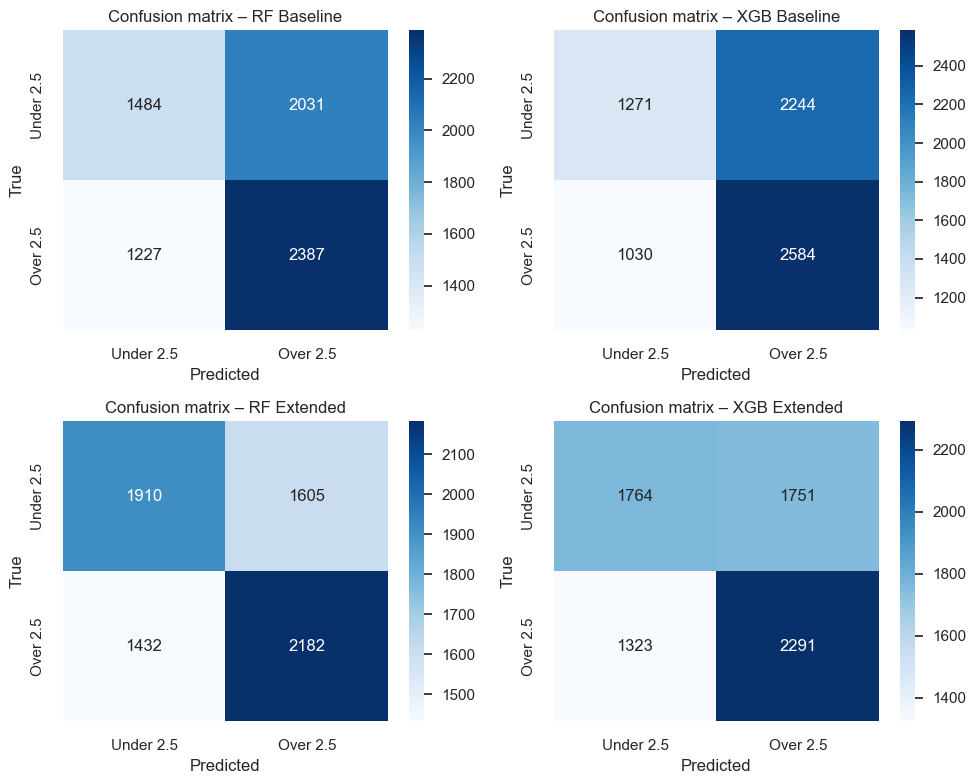

In [70]:
# Plotting confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for (name, kind, model, X_test, y_test), ax in zip(models, axes.flatten()):
    # XGBoost: use renamed copy of columns
    if kind == "xgb":
        X_eval = X_test.rename(columns=rename_map)
    else:
        X_eval = X_test

    y_pred = model.predict(X_eval)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Under 2.5", "Over 2.5"],
        yticklabels=["Under 2.5", "Over 2.5"],
        ax=ax
    )
    ax.set_title(f"Confusion matrix – {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


Both extended models have large improvement at correctly recognizing matches with Under 2.5 goals scored (rf: 1484 -> 1910, xgboost: 1271 -> 1764) at the expenses of lower correct classification of Over 2.5 gaols. Thus increasing accuracy

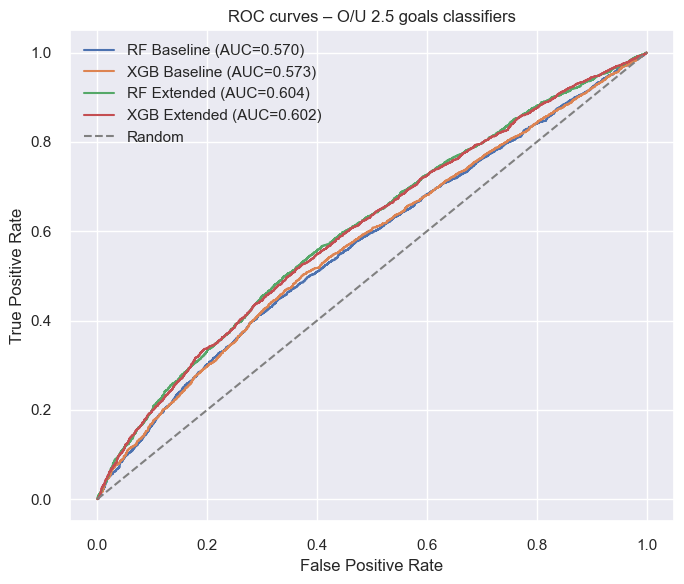

In [71]:
plt.figure(figsize=(7, 6))

for name, kind, model, X_test, y_test in models:
    if kind == "xgb":
        X_eval = X_test.rename(columns=rename_map)
    else:
        X_eval = X_test

    proba = model.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves – O/U 2.5 goals classifiers")
plt.legend()
plt.tight_layout()
plt.show()


In [72]:
metrics_df.sort_values(by = "LogLoss")

,Model,LogLoss,Accuracy,Precision,Recall,F1,ROC_AUC
2,RF Extended,0.676275,0.573994,0.576182,0.603763,0.589650,0.603923
3,XGB Extended,0.676761,0.568803,0.566799,0.633924,0.598485,0.602049
0,RF Baseline,0.686172,0.542993,0.540290,0.660487,0.594373,0.570408
1,XGB Baseline,0.688319,0.540749,0.535211,0.714997,0.612177,0.573140


LogLoss was pretty similiar accross all models.

Both LogLoss and accuracy were best for extended random forest. With an increase of 5.7% for accuracy and 1.68% for logloss compared to the baseline version. 

XGBoost had an increase in accuracy of 5.2% from baseline model to extended model. LogLoss improved by 1.44%.


# 3 Model comparison by countries

In [73]:
# Create a new dataset divided into country leagues
div_cols = [c for c in X_test_basic.columns if c.startswith("Div_")]
test_leagues = X_test_basic[div_cols].idxmax(axis=1)
test_leagues = test_leagues.str.replace("^Div_", "", regex=True)


metrics_country_rows = []
unique_leagues = sorted(test_leagues.unique())

for league in unique_leagues:
    mask = (test_leagues == league)

    for name, kind, model, X_test, y_test in models:
        X_sub = X_test[mask]
        y_sub = y_test[mask]

        # Renamed columns for xgboost
        if kind == "xgb":
            X_eval = X_sub.rename(columns=rename_map)
        else:
            X_eval = X_sub

        # Predict probabilities and class labels
        proba = model.predict_proba(X_eval)[:, 1]
        y_pred = (proba >= 0.5).astype(int)

        metrics_country_rows.append({
            "League": league,
            "Model": name,
            "n_matches": mask.sum(),
            "LogLoss": log_loss(y_sub, proba),
            "Accuracy": accuracy_score(y_sub, y_pred),
            "Precision": precision_score(y_sub, y_pred, zero_division=0),
            "Recall": recall_score(y_sub, y_pred, zero_division=0),
            "F1": f1_score(y_sub, y_pred, zero_division=0),
            "ROC_AUC": roc_auc_score(y_sub, proba),
        })

metrics_country_df = pd.DataFrame(metrics_country_rows)
metrics_country_df.sort_values(by = "LogLoss")


,League,Model,n_matches,LogLoss,Accuracy,Precision,Recall,F1,ROC_AUC
6,D1,RF Extended,306,0.637113,0.627451,0.626374,0.934426,0.750000,0.675508
7,D1,XGB Extended,306,0.639709,0.614379,0.615658,0.945355,0.745690,0.673686
82,T1,RF Extended,342,0.651809,0.587719,0.600000,0.761905,0.671329,0.646540
54,P1,RF Extended,306,0.654628,0.627451,0.652542,0.513333,0.574627,0.651581
83,T1,XGB Extended,342,0.656602,0.570175,0.582031,0.788360,0.669663,0.640039
...,...,...,...,...,...,...,...,...,...
36,G1,RF Baseline,233,0.703156,0.523605,0.495050,0.454545,0.473934,0.532373
64,SC3,RF Baseline,180,0.703547,0.511111,0.522124,0.634409,0.572816,0.493758
60,SC2,RF Baseline,180,0.705066,0.488889,0.472603,0.821429,0.600000,0.534474
65,SC3,XGB Baseline,180,0.707228,0.533333,0.531469,0.817204,0.644068,0.496230


In [120]:
# 2) Merge leagues into countries by league prefix
metrics_country_df["Country"] = (
    metrics_country_df["League"]
    .str.replace(r"\d+", "", regex=True)
    .str.strip()
)

# Aggregate metrics at country level
metric_cols = ["LogLoss", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]

metrics_country_agg = (
    metrics_country_df
    .groupby(["Country", "Model"], as_index=False)
    .agg(
        n_matches=("n_matches", "sum"),
        **{m: (m, "mean") for m in metric_cols}
    )
)

# Rename to full country names
code_to_country = {
    "B":  "Belgium",
    "D":  "Germany",
    "E":  "England",
    "F":  "France",
    "G":  "Greece",
    "I":  "Italy",
    "N":  "Netherlands",
    "P":  "Portugal",
    "SC": "Scotland",
    "SP": "Spain",
    "T":  "Turkey",
}
metrics_country_agg["Country"] = metrics_country_agg["Country"].map(code_to_country)


metrics_country_agg.sort_values(by="Accuracy", ascending=False)


,Country,Model,n_matches,LogLoss,Accuracy,Precision,Recall,F1,ROC_AUC
29,Portugal,RF Extended,306,0.654628,0.627451,0.652542,0.513333,0.574627,0.651581
5,Germany,RF Extended,612,0.649907,0.620915,0.619131,0.947982,0.748932,0.633948
31,Portugal,XGB Extended,306,0.657445,0.620915,0.651786,0.486667,0.557252,0.645641
7,Germany,XGB Extended,612,0.650748,0.614379,0.613385,0.956194,0.747313,0.632638
25,Netherlands,RF Extended,306,0.683417,0.601307,0.591440,0.899408,0.713615,0.569343
30,Portugal,XGB Baseline,306,0.676131,0.598039,0.583851,0.626667,0.604502,0.614573
6,Germany,XGB Baseline,612,0.663058,0.598039,0.600381,0.975335,0.743232,0.598194
13,France,RF Extended,612,0.677259,0.596405,0.628682,0.584134,0.579181,0.592330
39,Spain,XGB Extended,842,0.670688,0.596155,0.642127,0.398933,0.477066,0.624429
4,Germany,RF Baseline,612,0.665583,0.591503,0.597865,0.961553,0.737147,0.583427


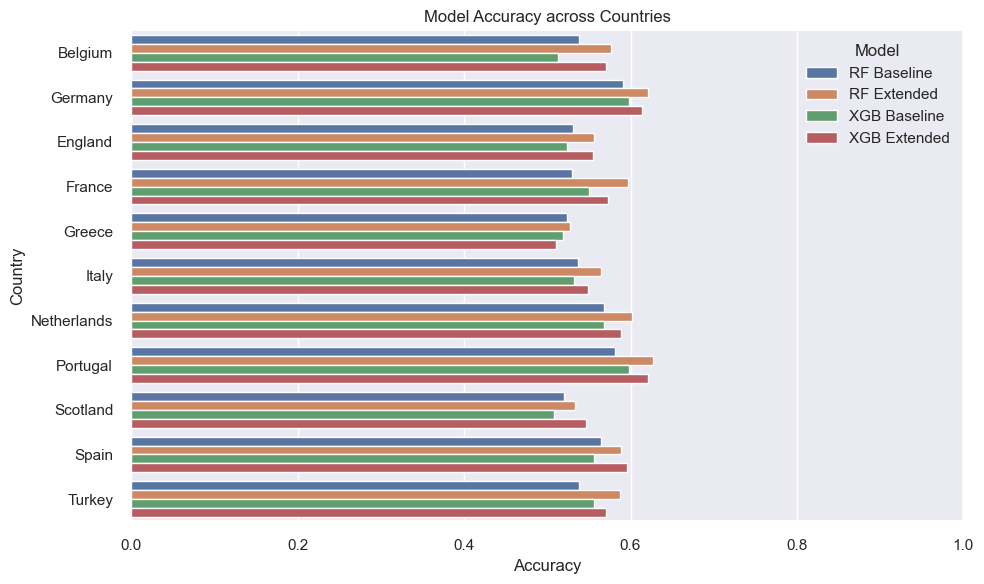

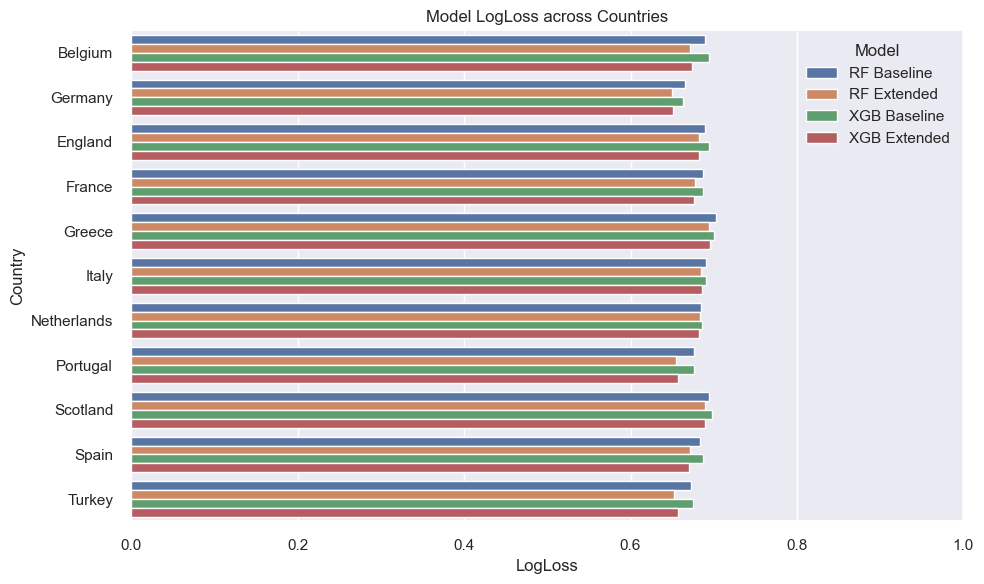

In [81]:
# Accuracy across countries
plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_country_agg,
    y="Country",
    x="Accuracy",
    hue="Model",
)
plt.title("Model Accuracy across Countries")
plt.xlabel("Accuracy")
plt.ylabel("Country")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# LogLoss across countries
plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_country_agg,
    y="Country",
    x="LogLoss",
    hue="Model",
)
plt.title("Model LogLoss across Countries")
plt.xlabel("LogLoss")
plt.ylabel("Country")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


Highest accuracy (0.63) was reached by extended random forest in Portugal, followed by extended random forest in Germany (0.62), extended XGBoost in Portugal (0.62) and Germany (0.61), and extended random forest in Netherlands (0.60).

Portugal and Germany had the highest overall accuracy accross countries.


In [132]:
# Accuracy improvements per country
acc_pivot = metrics_country_agg.pivot(
    index="Country",
    columns="Model",
    values="Accuracy"
)

acc_pivot["RF_improvement"]  = acc_pivot["RF Extended"]  - acc_pivot["RF Baseline"]
acc_pivot["XGB_improvement"] = acc_pivot["XGB Extended"] - acc_pivot["XGB Baseline"]
acc_pivot["Mean_improvement"] = (acc_pivot["RF_improvement"] + acc_pivot["XGB_improvement"])/2

improvements = acc_pivot[["RF_improvement", "XGB_improvement", "Mean_improvement"]].reset_index()
improvements.sort_values(by = "Mean_improvement", ascending=False)


Model,Country,RF_improvement,XGB_improvement,Mean_improvement
0,Belgium,0.038462,0.057692,0.048077
2,France,0.066993,0.022876,0.044935
7,Portugal,0.045752,0.022876,0.034314
9,Spain,0.024892,0.040362,0.032627
10,Turkey,0.049708,0.014620,0.032164
1,England,0.024909,0.030668,0.027789
6,Netherlands,0.032680,0.019608,0.026144
8,Scotland,0.013670,0.038304,0.025987
3,Germany,0.029412,0.016340,0.022876
5,Italy,0.027632,0.017105,0.022368


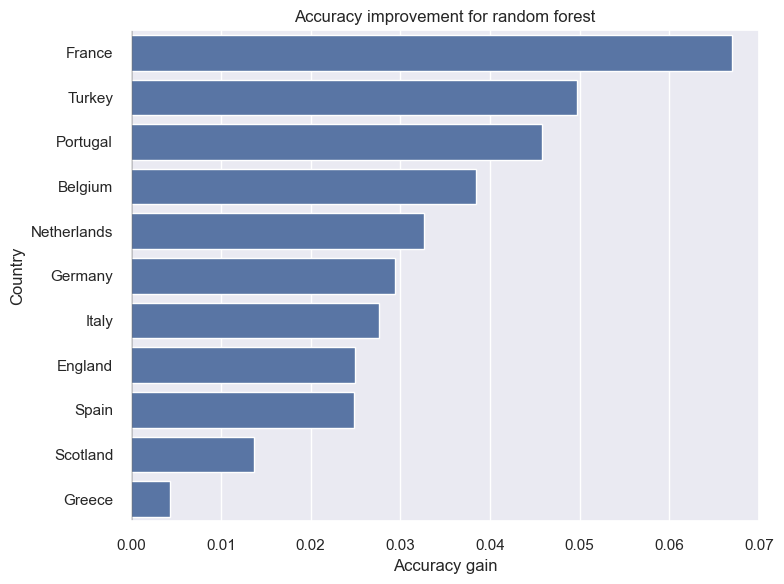

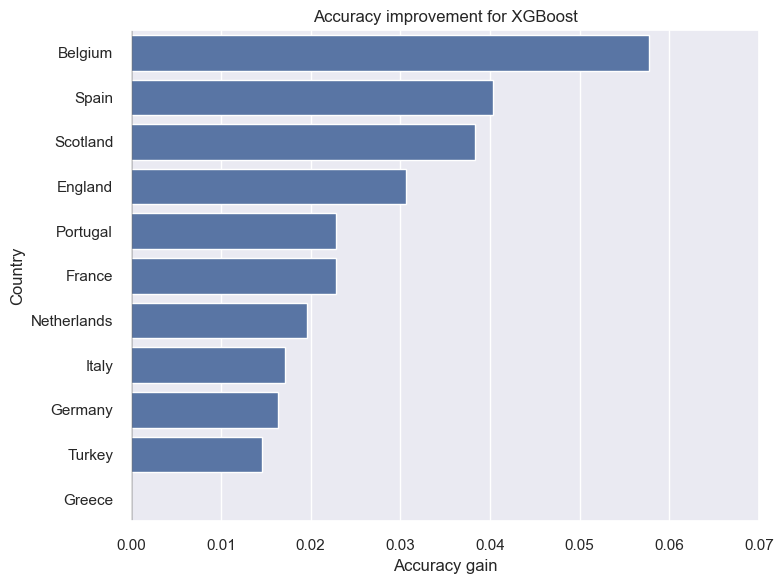

In [126]:
# Sort by RF improvement
rf_imp = improvements.sort_values("RF_improvement", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=rf_imp,
    y="Country",
    x="RF_improvement"
)
plt.title("Accuracy improvement for random forest")
plt.xlabel("Accuracy gain")
plt.ylabel("Country")
plt.axvline(0, color="black", linewidth=1)
plt.xlim(0, 0.07)
plt.tight_layout()
plt.show()

# Sort by RF improvement
xgb_imp = improvements.sort_values("XGB_improvement", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=xgb_imp,
    y="Country",
    x="XGB_improvement"
)
plt.title("Accuracy improvement for XGBoost")
plt.xlabel("Accuracy gain")
plt.ylabel("Country")
plt.axvline(0, color="black", linewidth=1)
plt.xlim(0,0.07)
plt.tight_layout()
plt.show()

Random forest improved in every country when using the extended dataset. The highest improvement was in accuracy was in:
- France (6.7%)
- Turkey (5%)
- Portugal (4.5%)

XGBoost improved in all countries except for Greece, with 0.8% decrease in accuracy. The largest improvements were in:
- Belgium (5.7%)
- Spain (4%) 
- Scotland (3.8%)

The best average improvements were in:
- Belgium (4.8%)
- France (4.5%)

# 4 Optimal profit margin

## 4.1 Setup

In [76]:
# Parameters
m_operations = 0.03
k = 0.3
alpha = 1000
epsilon = 3
b = 12

# Best accuracies for baseline and extended data
A0 = max(metrics_df[metrics_df['Model'] == 'XGB Baseline']['Accuracy'].values[0], metrics_df[metrics_df['Model'] == 'RF Baseline']['Accuracy'].values[0])
A1 = max(metrics_df[metrics_df['Model'] == 'XGB Extended']['Accuracy'].values[0], metrics_df[metrics_df['Model'] == 'RF Extended']['Accuracy'].values[0])

# Functions
risk_margin = lambda A: k * (1 - A)
total_margin = lambda m_profit, A: m_profit + m_operations + risk_margin(A)
volume = lambda m: alpha  *m**(-epsilon)
profit = lambda m_profit, A: volume(total_margin(m_profit, A))  *m_profit*  b

## 4.2 Analytical Solution

**Given:**
- $\Pi(m_{\text{profit}}) = V(m) \cdot m_{\text{profit}} \cdot b$
- $V(m) = \alpha \cdot m^{-\varepsilon}$
- $m = m_{\text{profit}} + m_{\text{operations}} + k(1-A)$

**Substituting:**

$$\Pi(m_{\text{profit}}) = \alpha \cdot (m_{\text{profit}} + m_{\text{operations}} + k(1-A))^{-\varepsilon} \cdot m_{\text{profit}} \cdot b$$

**To maximize, we take derivative and set to zero:**

$$\frac{d\Pi}{dm_{\text{profit}}} = 0$$

**Using product rule:**

$$\frac{d\Pi}{dm_{\text{profit}}} = \alpha \cdot b \cdot m^{-\varepsilon} + m_{\text{profit}} \cdot \alpha \cdot b \cdot (-\varepsilon) \cdot m^{-\varepsilon-1}$$

$$= \alpha \cdot b \cdot m^{-\varepsilon-1} \cdot [m - \varepsilon \cdot m_{\text{profit}}]$$

**Setting equal to zero:**

$$m - \varepsilon \cdot m_{\text{profit}} = 0$$

$$m = \varepsilon \cdot m_{\text{profit}}$$

**Therefore:**

$$m_{\text{profit}} + m_{\text{operations}} + k(1-A) = \varepsilon \cdot m_{\text{profit}}$$

$$m_{\text{profit}}(\varepsilon - 1) = m_{\text{operations}} + k(1-A)$$

$$\boxed{m_{\text{profit}}^* = \frac{m_{\text{operations}} + k(1-A)}{\varepsilon - 1}}$$

In [77]:
# Calculate analytical solution

def analytical_optimal_profit_margin(A):
  return (m_operations + k*(1-A)) / (epsilon - 1)

m_profit_analytical = analytical_optimal_profit_margin(A1)
print(f"Analytical solution for A1 = {A1}:")
print(f" m_profit* = [{m_operations} + {k}(1-{A1})] / ({epsilon} - 1)")
print(f" m_profit* = {m_profit_analytical:.4f}")

Analytical solution for A1 = 0.5739935474821153:
 m_profit* = [0.03 + 0.3(1-0.5739935474821153)] / (3 - 1)
 m_profit* = 0.0789


## 4.3 Numerical verification

In [78]:
# Current state - calculate optimal margin for A0
m_profit_0 = analytical_optimal_profit_margin(A0)
m0_total = total_margin(m_profit_0, A0)

# Find optimal profit margin for A1 numerically
result = minimize_scalar(lambda m: -profit(m, A1), bounds=(0.01, 0.5), method='bounded')
m_profit_numerical = result.x
profit_A0 = profit(m_profit_0, A0)
profit_A1_optimal = -result.fun
print(f"Numerical solution (minimize_scalar): {m_profit_numerical:.5f}")
print(f"Analytical solution: {m_profit_analytical:.5f}")
print(f"Difference: {abs(m_profit_numerical - m_profit_analytical):.6f}")

Numerical solution (minimize_scalar): 0.07890
Analytical solution: 0.07890
Difference: 0.000001


## 4.4 Results

In [79]:
# Results using analytical solution and overall accuracies
profit_A1_analytical = profit(m_profit_analytical, A1)
delta_profit = profit_A1_analytical - profit_A0

print(f"Current profit (A0={A0}): ${profit_A0:.2f}")
print(f"Optimal profit margin for A1={A1}: {m_profit_analytical:.4f}")
print(f"Optimal profit (A1): ${profit_A1_analytical:.2f}")
print(f"\nProfit improvement = maximum price for extended data: ${delta_profit:.2f}")

Current profit (A0=0.5429934072099873): $63666.99
Optimal profit margin for A1=0.5739935474821153: 0.0789
Optimal profit (A1): $71392.54

Profit improvement = maximum price for extended data: $7725.55
